<a href="https://colab.research.google.com/github/Ephraimosse9/Pytorch-course-on-UDEMY--Notes-and-Codes/blob/main/ClassificationFood101dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code to classify 20% of the Food101 dataset
Since the full dataset is quite large, the goal here is to experiment with a smaller subset (20%) before scaling to larger and more effective versions. Two scenarios are considered:

Without transfer learning – to test if the model can train from scratch.

With transfer learning – to compare performance improvements when leveraging pretrained models.

In [ ]:
#importing important Linraries
import requests
import os
from pathlib import Path
import zipfile
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy


In [ ]:
#set a fuction for manual seed

def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
set_seed(42)

##Downloading data from github

In [ ]:
#The subset of food101 used is gotten from github
data_dir = Path("data")
image_path = data_dir/"pizza_steak_sushi"

if image_path.is_dir():
  print("File path already present, ABORTING!!!!!!!!!")
else:
  print("Creating File Path!!!!!........")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_dir/"pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading file from GitHub")
    f.write(requests.content)

  with zipfile.ZipFile(data_dir/"pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)


File path already present, ABORTING!!!!!!!!!


##Becoming one with the data

###Let's walkthrough the data

In [ ]:
def walk_through(image_path=image_path):
  for dir_path, dir_names, file_names in os.walk(image_path):
    print(f"In the path {dir_path}, there are {len(dir_names)} directory, and {len(file_names)} files")

walk_through()

In the path data/pizza_steak_sushi, there are 2 directory, and 0 files
In the path data/pizza_steak_sushi/train, there are 3 directory, and 0 files
In the path data/pizza_steak_sushi/train/steak, there are 0 directory, and 146 files
In the path data/pizza_steak_sushi/train/sushi, there are 0 directory, and 150 files
In the path data/pizza_steak_sushi/train/pizza, there are 0 directory, and 154 files
In the path data/pizza_steak_sushi/test, there are 3 directory, and 0 files
In the path data/pizza_steak_sushi/test/steak, there are 0 directory, and 58 files
In the path data/pizza_steak_sushi/test/sushi, there are 0 directory, and 46 files
In the path data/pizza_steak_sushi/test/pizza, there are 0 directory, and 46 files


###Now lets get our training and test paths

In [ ]:
#This will be used when we want to use ImageFolder
test_dir = image_path/"test"
train_dir = image_path/"train"

##Now Lets visualize our data

###Visualizing with Pillow

In [ ]:
#For this we will use python pillows, that is PIL to visualize the data
import random
import PIL
from PIL import Image

set_seed(42)
image_list = list(image_path.glob("*/*/*.jpg"))
random_image = random.choice(image_list)
random_image_class = random_image.parent.stem
random_image_class
img = Image.open(random_image)
print(f"Random image path: {random_image}")
print(f"Random image class: {random_image_class}")
print(f"Random image Height: {img.height}")
print(f"Random image Width: {img.width}")
img

Random image path: data/pizza_steak_sushi/train/steak/1615395.jpg
Random image class: steak
Random image Height: 384
Random image Width: 512


###Visualizing with Matplotlib

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

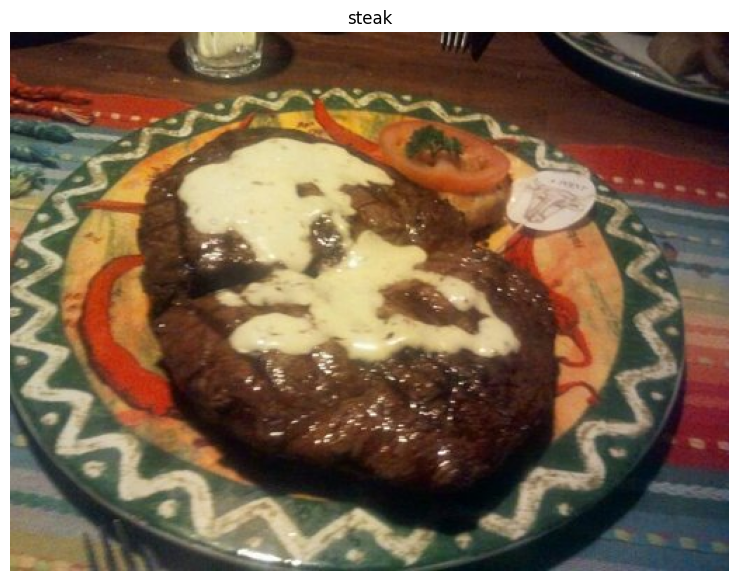

In [ ]:
image_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(image_array)
plt.title(random_image_class)
plt.axis(False)

##Applying data transforms

In [ ]:
set_seed(42)
transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

###Lets compare our images without transforms and with transforms

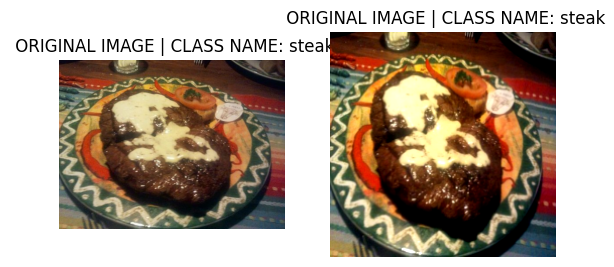

In [ ]:
def compare_images(image_list, n, seed):
  random.seed(seed)
  random_image_list = random.sample(image_list, k=n)

  for image_path in random_image_list:
    with Image.open(image_path) as img:
      #Original Image
      image = np.asarray(img)
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(image)
      ax[0].set_title(f" ORIGINAL IMAGE | CLASS NAME: {image_path.parent.stem}")
      ax[0].axis(False)

      #Transformed Image
      image2 = transforms(img).permute(1,2,0)
      ax[1].imshow(image2)
      ax[1].set_title(f" ORIGINAL IMAGE | CLASS NAME: {image_path.parent.stem}")
      ax[1].axis(False)

compare_images(image_list=image_list, n=3, seed=42)

##Loading our dataset

In [ ]:
train_data = datasets.ImageFolder(
    root= train_dir,
    transform=transforms,
)
test_data = datasets.ImageFolder(
    root= test_dir,
    transform=transforms,
)

In [ ]:
class_names = test_data.classes

###Turning our data into data loaders

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size= 1,
    shuffle = True,
    num_workers= os.cpu_count()
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size= 1,
    shuffle = False,
    num_workers= os.cpu_count()
)

In [ ]:
len(train_dataloader), len(test_dataloader)

(450, 150)

In [ ]:
def training_step(model, loss_fn, dataloader, optimizer, accuracy_fn, device):
  train_loss, train_acc = 0,0
  for X,y in dataloader:
    model.train()
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    train_loss1 = loss_fn(y_pred, y)
    train_acc1 = accuracy_fn(y_pred.argmax(dim=1), y)
    train_loss += train_loss1
    train_acc +=train_acc1
    optimizer.zero_grad()
    train_loss1.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [ ]:
def testing_step(model, loss_fn, dataloader, accuracy_fn, device):
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in dataloader:
      X,y = X.to(device), y.to(device)
      y_pred = model(X)
      test_loss1 = loss_fn(y_pred, y)
      test_acc1 = accuracy_fn(y_pred.argmax(dim=1), y)
      test_loss += test_loss1
      test_acc +=test_acc1

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

#Normal Model: No Transfer Learning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)
class FoodModel01(nn.Module):
  def __init__(self, colour_channel, hidden_units, output_shape):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=colour_channel, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=31360, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )


  def forward(self, x):
    return self.classifier(self.conv2(self.conv1(x)))

model0 = FoodModel01(colour_channel=3, hidden_units=10, output_shape=len(class_names)).to(device)

In [ ]:
accuracy_fn = Accuracy(task="multiclass", num_classes=3).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.01)

In [ ]:
from tqdm.auto import tqdm
epochs = 20
model0_results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = training_step(model=model0, loss_fn=loss_fn, dataloader=train_dataloader, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
  test_loss, test_acc = testing_step(model=model0, loss_fn=loss_fn, dataloader=test_dataloader, accuracy_fn=accuracy_fn, device=device)
  model0_results["train_loss"].append(train_loss.detach())
  model0_results["train_acc"].append(train_acc.detach())
  model0_results["test_loss"].append(test_loss.detach())
  model0_results["test_acc"].append(test_acc.detach())

  if epoch%5 == 0:
    print(f"Epochs: {epoch} | Training loss: {train_loss}, Training Accuracy: {train_acc} |  Testing loss: {test_loss}, Testing Accuracy: {test_acc}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epochs: 0 | Training loss: 1.103739619255066, Training Accuracy: 0.31333333253860474 |  Testing loss: 1.1025856733322144, Testing Accuracy: 0.30666667222976685
Epochs: 5 | Training loss: 1.1011765003204346, Training Accuracy: 0.3222222328186035 |  Testing loss: 1.1035077571868896, Testing Accuracy: 0.30666667222976685
Epochs: 10 | Training loss: 1.1015464067459106, Training Accuracy: 0.30444446206092834 |  Testing loss: 1.1021651029586792, Testing Accuracy: 0.30666667222976685
Epochs: 15 | Training loss: 1.101419448852539, Training Accuracy: 0.31111112236976624 |  Testing loss: 1.100953459739685, Testing Accuracy: 0.30666667222976685


In [ ]:
model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

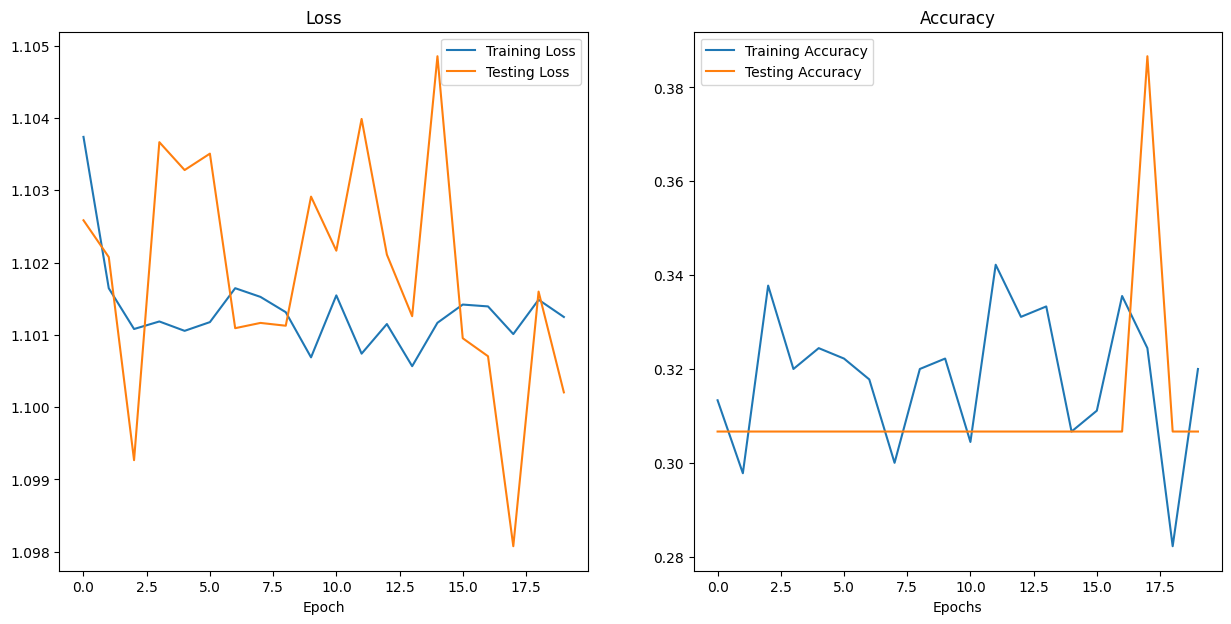

In [ ]:
def plot_loss_curves(results):
  train_loss = [loss.cpu().detach().numpy() for loss in results["train_loss"]]
  test_loss = [loss.cpu().detach().numpy() for loss in results["test_loss"]]

  train_acc = [acc.cpu().detach().numpy() for acc in results["train_acc"]]
  test_acc = [acc.cpu().detach().numpy() for acc in results["test_acc"]]
  Epochs = range(len(train_loss))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(Epochs, train_loss, label="Training Loss")
  plt.plot(Epochs, test_loss, label="Testing Loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(Epochs, train_acc, label="Training Accuracy")
  plt.plot(Epochs, test_acc, label="Testing Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(model0_results)

In [ ]:
import requests
test_image_path = data_dir/"dad_pizza.jpeg"

if test_image_path.is_file:
  with open(test_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
    print("Downloading test image.....")
    f.write(request.content)
    print("Image Downloaded!!!")
else:
  print("Image already present")

Image Downloaded!!!


In [ ]:
from torchvision import transforms
first_image_path =data_dir/"pizz.jpg"
second_image_path = data_dir/"sushi.jpg"
third_image_path = data_dir/"steak.jpg"

image_transform = transforms.Compose([
    transforms.Resize(size=(224,224))
])

In [ ]:
def check_prediction(model, image_path, class_names, transforms, device):
  image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255
  image_transformed = transforms(image).to(device)

  model.eval()
  with torch.inference_mode():
    y_pred = model(image_transformed.unsqueeze(dim=0))

  plt.figure(figsize=(10,7))
  plt.imshow(image_transformed.cpu().permute(1,2,0))
  title = f"pred class: {class_names[y_pred.argmax(dim=1)]} | Pred prob: {y_pred.softmax(dim=1).max(): .2f}"
  plt.title(title)
  plt.axis(False)

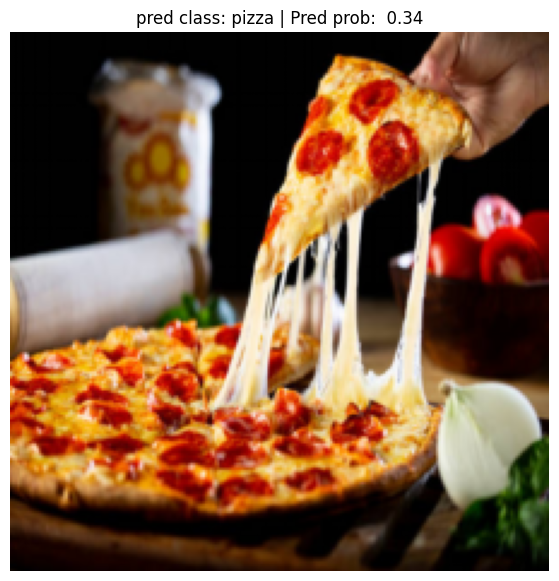

In [ ]:
check_prediction(model=model0, image_path=first_image_path, class_names= class_names, transforms=image_transform, device=device)

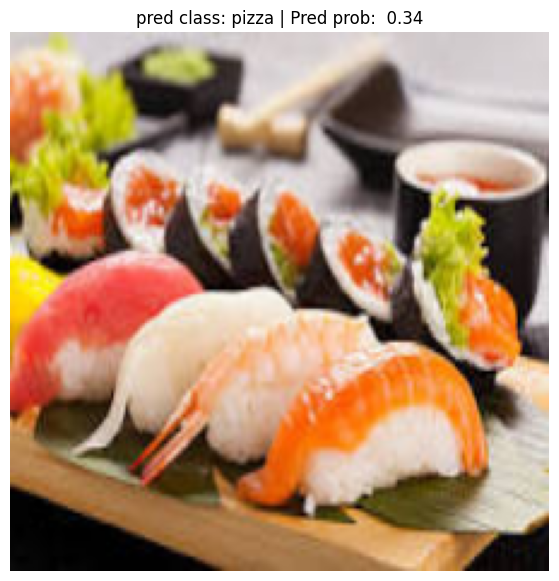

In [ ]:
check_prediction(model=model0, image_path=second_image_path, class_names= class_names, transforms=image_transform, device=device)


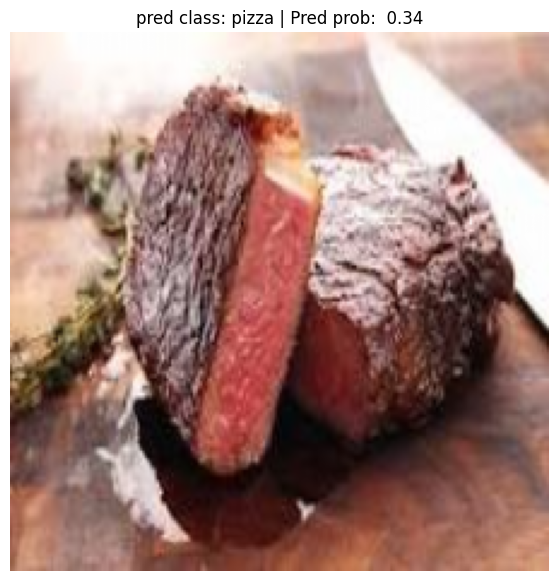

In [ ]:
check_prediction(model=model0, image_path=third_image_path, class_names= class_names, transforms=image_transform, device=device)


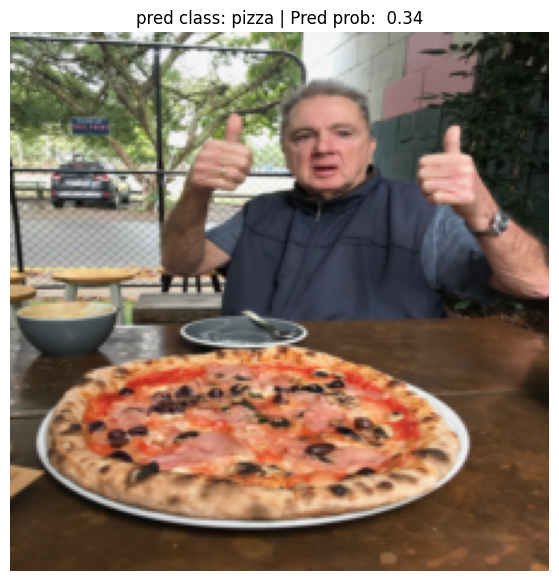

In [ ]:
check_prediction(model=model0, image_path=test_image_path , class_names= class_names, transforms=image_transform, device=device)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

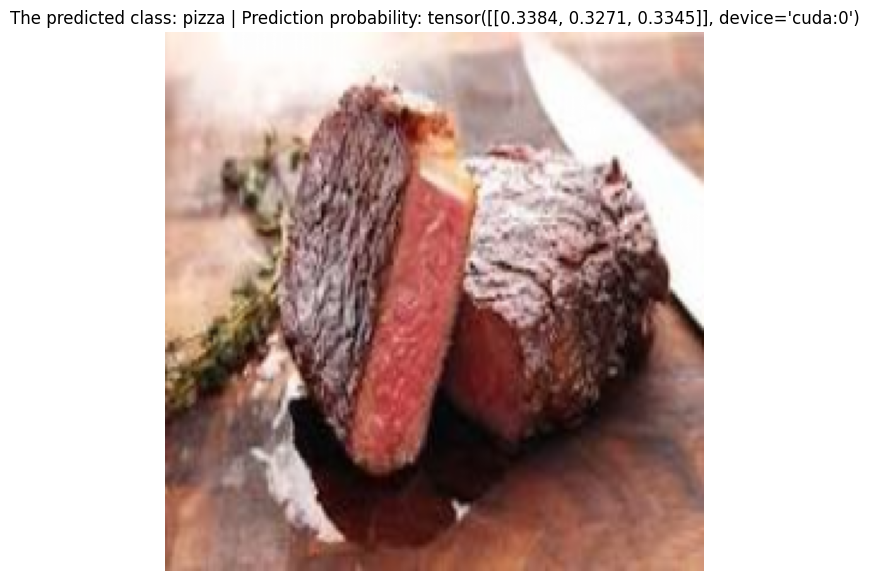

In [ ]:
image = torchvision.io.read_image(str(third_image_path)).type(torch.float32) / 255
image_transformed = image_transform(image).to(device)

model0.eval()
with torch.inference_mode():
  y_pred = model0(image_transformed.unsqueeze(dim=0))

plt.figure(figsize=(10,7))
plt.imshow(image_transformed.cpu().permute(1,2,0))
title = f"The predicted class: {class_names[y_pred.argmax(dim=1)]} | Prediction probability: {y_pred.softmax(dim=1)}"
plt.title(title)
plt.axis(False)

#With Transfer Learning

In [ ]:
import torchvision
from torchvision import models
set_seed(42)
#Getting Auto transformers

weights = models.EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()



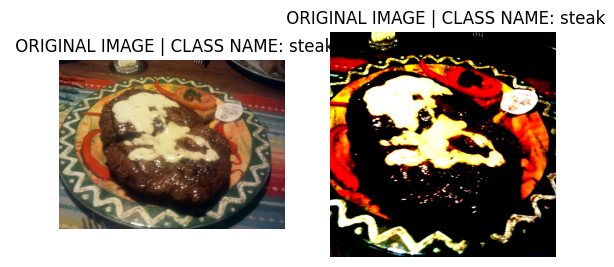

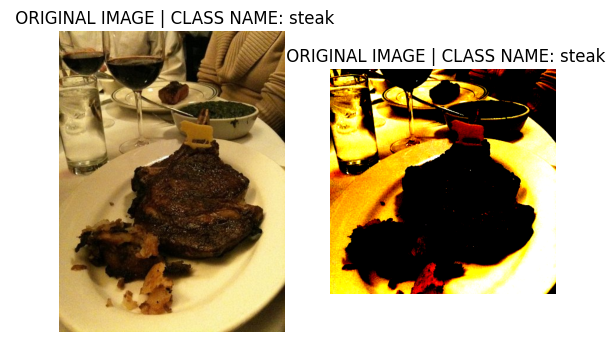

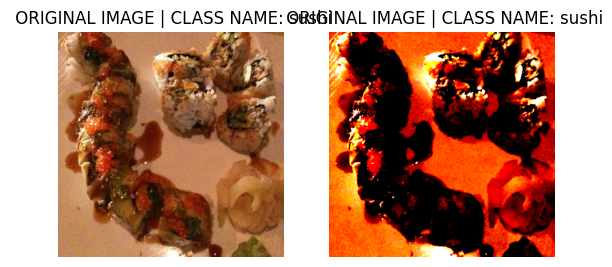

In [ ]:
#Lets see how this transform looks on our images

def compare_images(image_list, n, seed):
  random.seed(seed)
  random_image_list = random.sample(image_list, k=n)

  for image_path in random_image_list:
    with Image.open(image_path) as img:
      #Original Image
      image = np.asarray(img)
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(image)
      ax[0].set_title(f" ORIGINAL IMAGE | CLASS NAME: {image_path.parent.stem}")
      ax[0].axis(False)

      #Transformed Image
      image2 = auto_transforms(img).permute(1,2,0)
      ax[1].imshow(image2)
      ax[1].set_title(f" ORIGINAL IMAGE | CLASS NAME: {image_path.parent.stem}")
      ax[1].axis(False)

compare_images(image_list=image_list, n=3, seed=42)

In [ ]:
#Loading our data with the new transform
set_seed(42)
transfer_train_data = datasets.ImageFolder(
    root= train_dir,
    transform=auto_transforms,
    target_transform=None
)

transfer_test_data = datasets.ImageFolder(
    root= test_dir,
    transform=auto_transforms,
    target_transform=None
)

In [ ]:
#Turning our dataset into data loaders
set_seed(42)
transfer_traindataloader = DataLoader(
    dataset=transfer_train_data,
    batch_size= 10,
    shuffle= True,
    num_workers= os.cpu_count()
)

transfer_testdataloader = DataLoader(
    dataset=transfer_test_data,
    batch_size= 10,
    shuffle= False,
    num_workers= os.cpu_count()
)

len(transfer_traindataloader), len(transfer_testdataloader)

(45, 15)

In [ ]:
!pip install torchinfo

In [ ]:
#Now Lets create our pretrained model
set_seed(42)
from torchinfo import summary

model = models.efficientnet_v2_s(weights=weights).to(device)
summary(model, input_size=(32, 3, 224, 224), col_names= ["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24, 112

In [ ]:
#Now we will freeze all layers except the classifier layer
set_seed(42)
for param in model.features.parameters():
  param.requires_grad = False

summary(model, input_size=(1, 3, 224, 224), col_names= ["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 24, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 24, 112, 112]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 112, 112]    [1, 24, 112, 112]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 112, 112]    [1, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 24, 112, 112]    [1, 2

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
set_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

summary(model, input_size=(1, 3, 224, 224), col_names= ["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 24, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 24, 112, 112]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 112, 112]    [1, 24, 112, 112]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 112, 112]    [1, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 24, 112, 112]    [1, 2

In [ ]:
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
epoch = 3
set_seed(42)
from tqdm.auto import tqdm
epochs = 50
model_results = {"transfer_train_loss": [], "transfer_train_acc": [], "transfer_test_loss": [], "transfer_test_acc": []}
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = training_step(model=model, loss_fn=loss_fn2, dataloader=transfer_traindataloader, optimizer=optimizer2, accuracy_fn=accuracy_fn, device=device)
  test_loss, test_acc = testing_step(model=model, loss_fn=loss_fn2, dataloader=transfer_testdataloader, accuracy_fn=accuracy_fn, device=device)
  model_results["transfer_train_loss"].append(train_loss.detach())
  model_results["transfer_train_acc"].append(train_acc.detach())
  model_results["transfer_test_loss"].append(test_loss.detach())
  model_results["transfer_test_acc"].append(test_acc.detach())

  if epoch%10 ==0:
    print(f"Epochs: {epoch} | Training loss: {train_loss: .2f}, Training Accuracy: {train_acc: .2f}% |  Testing loss: {test_loss: .2f}%, Testing Accuracy: {test_acc: .2f}%")

  0%|          | 0/50 [00:00<?, ?it/s]

Epochs: 0 | Training loss:  0.41, Training Accuracy:  0.93% |  Testing loss:  0.35%, Testing Accuracy:  0.97%
Epochs: 1 | Training loss:  0.42, Training Accuracy:  0.86% |  Testing loss:  0.32%, Testing Accuracy:  0.94%
Epochs: 2 | Training loss:  0.39, Training Accuracy:  0.89% |  Testing loss:  0.29%, Testing Accuracy:  0.95%
Epochs: 3 | Training loss:  0.34, Training Accuracy:  0.90% |  Testing loss:  0.26%, Testing Accuracy:  0.95%
Epochs: 4 | Training loss:  0.36, Training Accuracy:  0.88% |  Testing loss:  0.25%, Testing Accuracy:  0.97%
Epochs: 5 | Training loss:  0.32, Training Accuracy:  0.90% |  Testing loss:  0.23%, Testing Accuracy:  0.95%
Epochs: 6 | Training loss:  0.31, Training Accuracy:  0.89% |  Testing loss:  0.22%, Testing Accuracy:  0.94%
Epochs: 7 | Training loss:  0.29, Training Accuracy:  0.89% |  Testing loss:  0.21%, Testing Accuracy:  0.96%
Epochs: 8 | Training loss:  0.27, Training Accuracy:  0.93% |  Testing loss:  0.21%, Testing Accuracy:  0.96%
Epochs: 9 

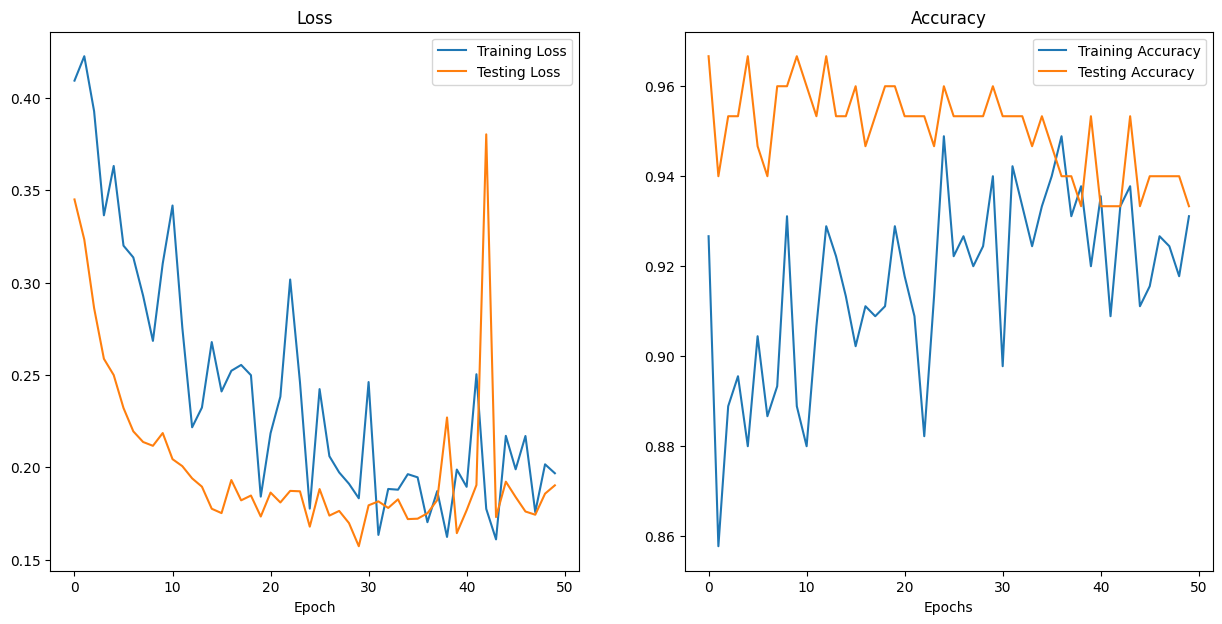

In [ ]:
def transfer_plot_loss_curves(results):
  train_loss = [loss.cpu().detach().numpy() for loss in results["transfer_train_loss"]]
  test_loss = [loss.cpu().detach().numpy() for loss in results["transfer_test_loss"]]

  train_acc = [acc.cpu().detach().numpy() for acc in results["transfer_train_acc"]]
  test_acc = [acc.cpu().detach().numpy() for acc in results["transfer_test_acc"]]
  Epochs = range(len(train_loss))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(Epochs, train_loss, label="Training Loss")
  plt.plot(Epochs, test_loss, label="Testing Loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(Epochs, train_acc, label="Training Accuracy")
  plt.plot(Epochs, test_acc, label="Testing Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

transfer_plot_loss_curves(model_results)

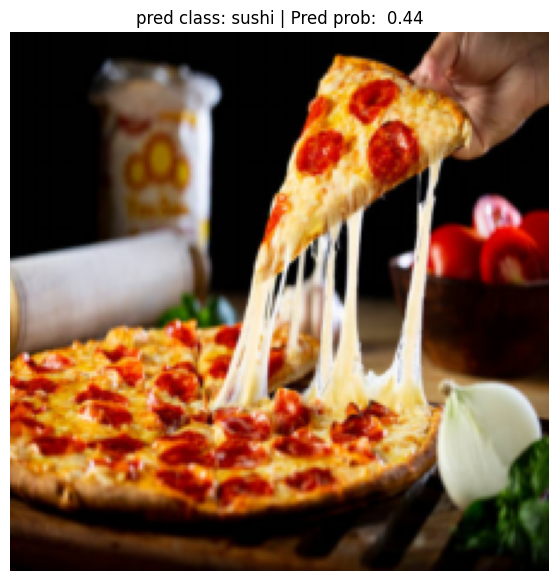

In [ ]:
check_prediction(model=model, image_path=first_image_path, class_names= class_names, transforms=image_transform, device=device)


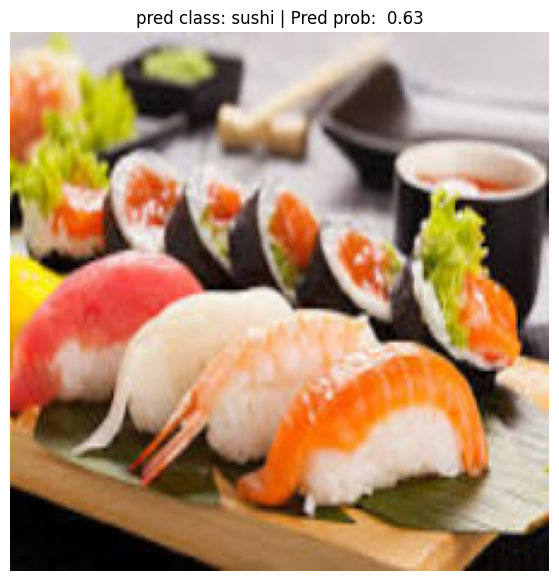

In [ ]:
check_prediction(model=model, image_path=second_image_path, class_names= class_names, transforms=image_transform, device=device)

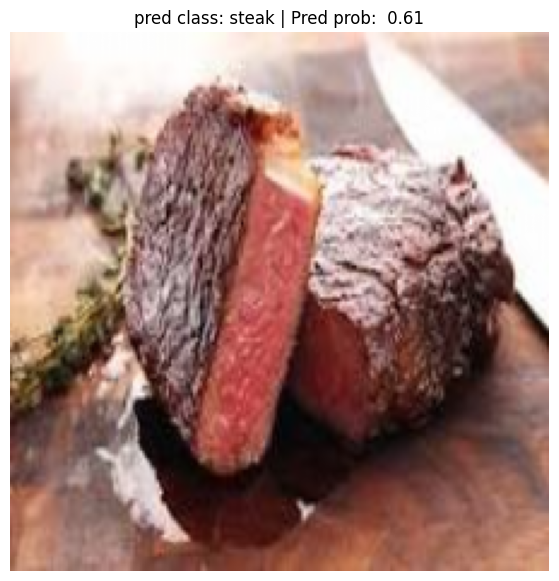

In [ ]:
check_prediction(model=model, image_path=third_image_path, class_names= class_names, transforms=image_transform, device=device)


In [ ]:
check_prediction(model=model, image_path=test_image_path, class_names= class_names, transforms=image_transform, device=device)
